In [93]:
%load_ext autoreload
%autoreload 2

import os
import time
import yaml
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits
import sklearn
from tqdm.autonotebook import tqdm
import itertools

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from scipy.spatial.distance import pdist,cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import MultiDataset
from memflow.callbacks.clustering_callbacks import *
from memflow.models.custom_flows import *
from memflow.models.transformer_autoencoder import TAE

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on GPU : False
Accelerator : cpu


# Load tensors #

In [94]:
outdir = '/nfs/scratch/fynu/fbury/MEMFlow_data/clustering'
latent_train = torch.load(os.path.join(outdir,'latent_train'),map_location=torch.device('cpu'))
x_train      = torch.load(os.path.join(outdir,'x_train'),map_location=torch.device('cpu'))
mask_train   = torch.load(os.path.join(outdir,'mask_train'),map_location=torch.device('cpu'))
process_train= torch.load(os.path.join(outdir,'process_train'),map_location=torch.device('cpu'))
latent_valid = torch.load(os.path.join(outdir,'latent_valid'),map_location=torch.device('cpu'))
x_valid      = torch.load(os.path.join(outdir,'x_valid'),map_location=torch.device('cpu'))
mask_valid   = torch.load(os.path.join(outdir,'mask_valid'),map_location=torch.device('cpu'))
process_valid= torch.load(os.path.join(outdir,'process_valid'),map_location=torch.device('cpu'))

print (f'Training {latent_train.shape}, Validation {latent_valid.shape}')

Training torch.Size([571715, 32]), Validation torch.Size([63524, 32])


# K-means

In [44]:
kmeans = KMeans(
    n_clusters = 100,
    init = 'k-means++',
    max_iter = 500,
    verbose = 1,
)
kmeans.fit(latent_train)

Initialization complete
Iteration 0, inertia 173872.87788905372.
Iteration 1, inertia 144145.21958533695.
Iteration 2, inertia 141164.7882180582.
Iteration 3, inertia 139806.8327340774.
Iteration 4, inertia 138993.42210214862.
Iteration 5, inertia 138445.37570953087.
Iteration 6, inertia 138041.00029312813.
Iteration 7, inertia 137724.66438873828.
Iteration 8, inertia 137461.74010057686.
Iteration 9, inertia 137235.15345280574.
Iteration 10, inertia 137052.28520804204.
Iteration 11, inertia 136904.34810575488.
Iteration 12, inertia 136785.04427474603.
Iteration 13, inertia 136689.12842213796.
Iteration 14, inertia 136606.31063129706.
Iteration 15, inertia 136532.14612428346.
Iteration 16, inertia 136467.43620633808.
Iteration 17, inertia 136410.7965115287.
Iteration 18, inertia 136361.41891655806.
Iteration 19, inertia 136318.83544720092.
Iteration 20, inertia 136280.1182679896.
Iteration 21, inertia 136243.91864737397.
Iteration 22, inertia 136213.05687028405.
Iteration 23, inertia 13

KMeans(max_iter=500, n_clusters=100, verbose=1)

# Study distances 

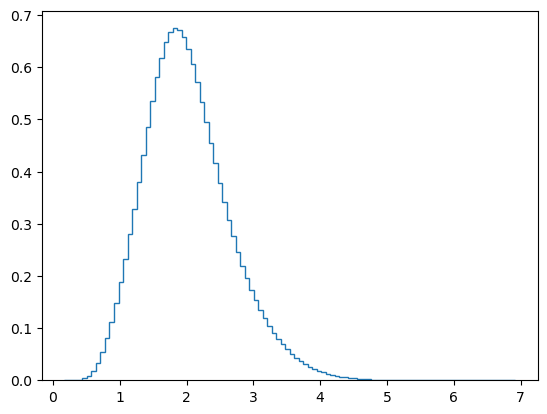

In [7]:
def choice_tensor(tensor,N):
    idx = torch.randperm(tensor.size(0))
    return tensor[idx[:N]]

all_distances = pdist(choice_tensor(latent_valid,10000))
bins = np.linspace(all_distances.min(),all_distances.max(),101)
all_content,_ = np.histogram(all_distances,bins=bins,density=True)
plt.stairs(
    all_content,
    bins
)

Clusters:   0%|                                          | 0/12 [00:00<?, ?it/s]

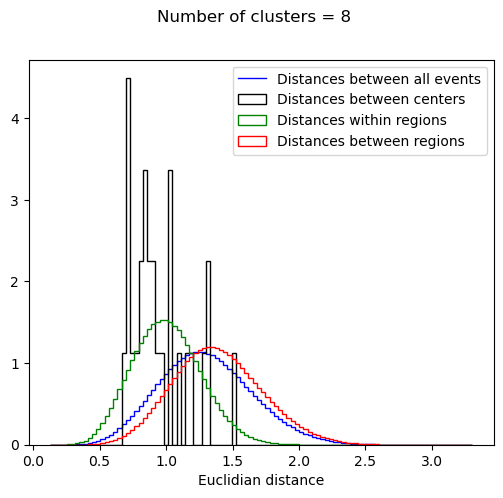

Clusters:   8%|██▊                               | 1/12 [00:06<01:09,  6.35s/it]

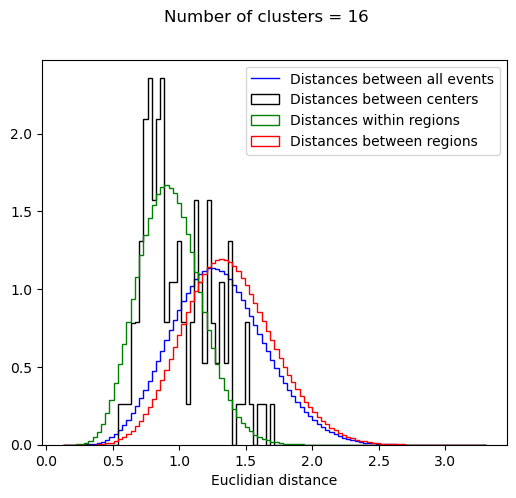

Clusters:  17%|█████▋                            | 2/12 [00:23<02:08, 12.85s/it]

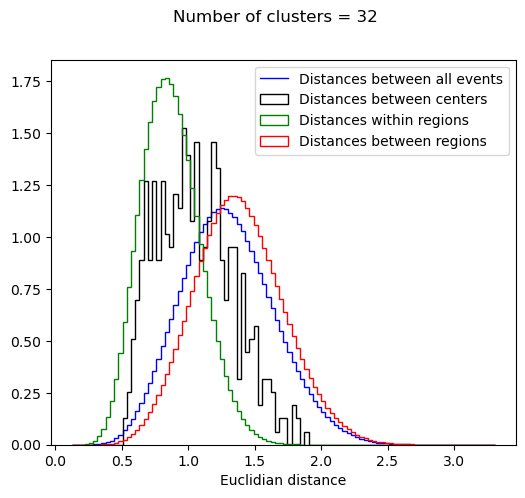

Clusters:  25%|████████▌                         | 3/12 [00:52<02:59, 19.96s/it]

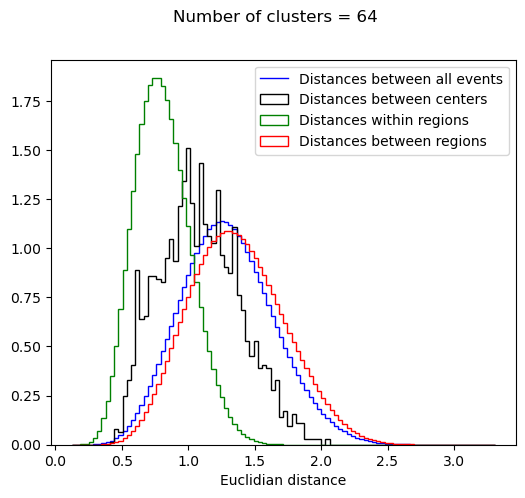

Clusters:  33%|███████████▎                      | 4/12 [01:24<03:20, 25.01s/it]

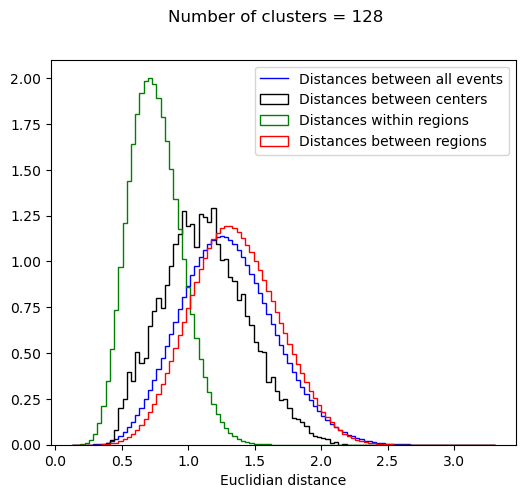

Clusters:  42%|██████████████▏                   | 5/12 [02:13<03:53, 33.38s/it]

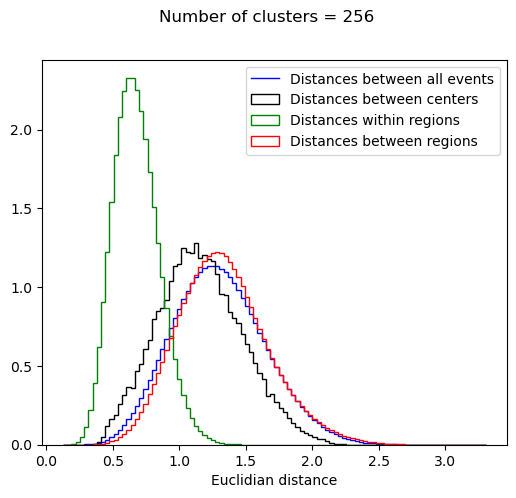

Clusters:  50%|█████████████████                 | 6/12 [03:18<04:25, 44.28s/it]

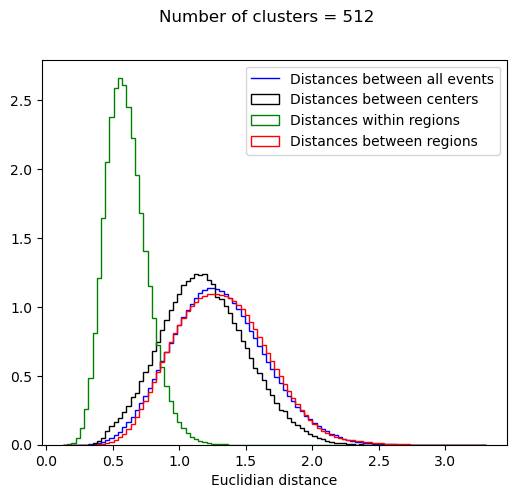

Clusters:  58%|███████████████████▊              | 7/12 [04:36<04:36, 55.37s/it]

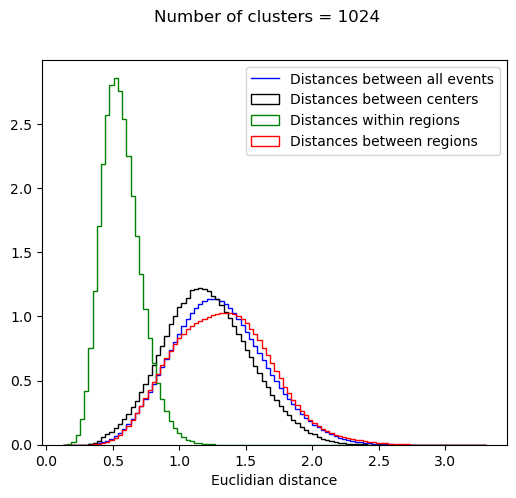

Clusters:  67%|██████████████████████▋           | 8/12 [06:47<05:17, 79.44s/it]

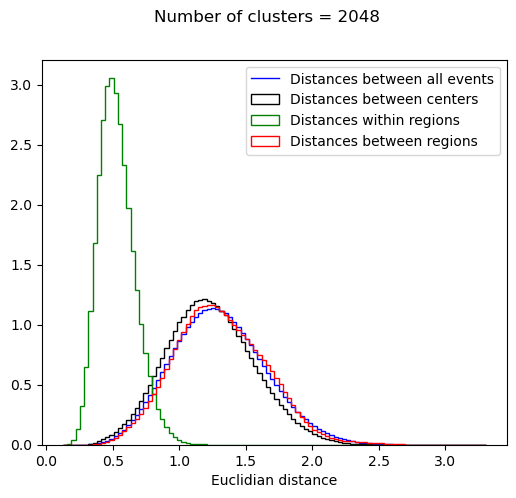

Clusters:  75%|████████████████████████▊        | 9/12 [11:51<07:28, 149.42s/it]

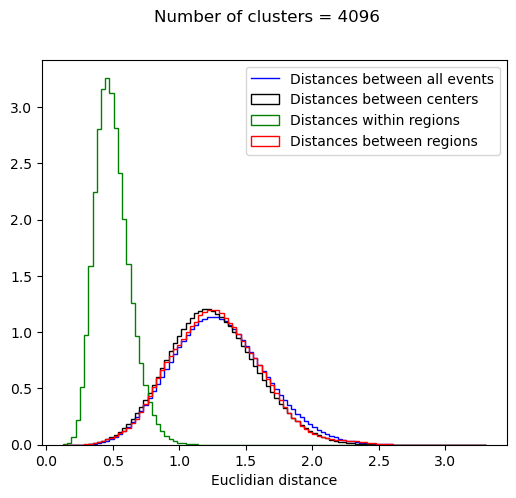

Clusters:  83%|██████████████████████████▋     | 10/12 [18:54<07:48, 234.05s/it]

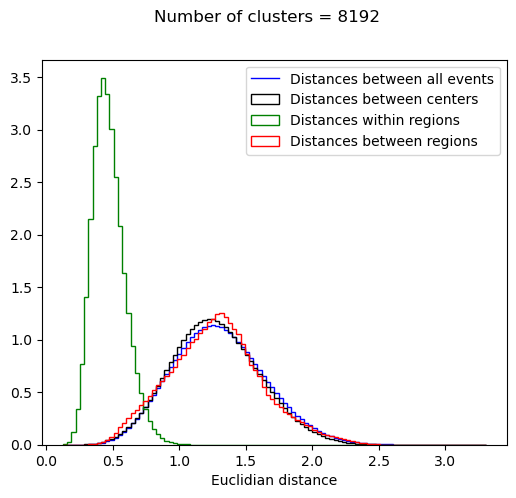

Clusters:  92%|█████████████████████████████▎  | 11/12 [31:10<06:27, 387.57s/it]

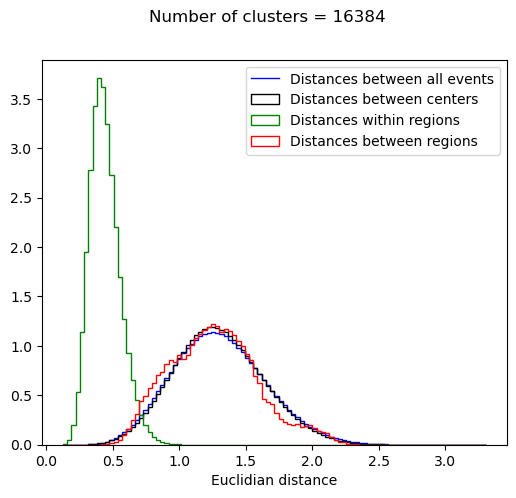

Clusters: 100%|████████████████████████████████| 12/12 [54:30<00:00, 272.56s/it]


In [55]:
inertias = []
coverages = []
silouhettes = []
n_clusters = [8,16,32,64,128,256,512,1024,2048,4096,8192,16384]


for n_cluster in tqdm(n_clusters,desc='Clusters',position=0,leave=True):
    # Fit #
    kmeans = KMeans(
        n_clusters = n_cluster,
        init = 'k-means++',
        max_iter = 1000,
        verbose = 0,
    )
    kmeans.fit(choice_tensor(latent_train,500000))

    # Predict #
    idx_center = kmeans.predict(latent_valid)

    # Metrics #
    inertia = 0.
    for idx in range(n_cluster):
        latent_region = latent_valid[idx_center == idx]
        center = kmeans.cluster_centers_[idx]
        inertia += (latent_region - center).pow(2).sum()
    inertias.append(inertia)
    # silouhettes.append(silhouette_score(latent_valid, idx_center))
    # print ('silouhettes done')

    # Get centers and their distances #
    centers = kmeans.cluster_centers_
    centers_distances = pdist(centers)

    # Get distances within regions #
    inside_regions_distance = []
    for idx in tqdm(range(n_cluster),desc='Inside Regions',position=1,leave=False,disable=True):
        latent_region = latent_valid[idx_center == idx]
        inside_regions_distance.append(pdist(choice_tensor(latent_region,1000)))
    inside_regions_distance = np.concatenate(inside_regions_distance,axis=0)

    # Get distances between regions #
    idx_combinations = list(set(itertools.combinations(np.arange(n_cluster),2)))[:200]
    outside_regions_distance = []
    for i,j in tqdm(idx_combinations,desc='Outside Regions',position=1,leave=False,disable=True):
        latent_region_i = latent_valid[idx_center == i]
        latent_region_j = latent_valid[idx_center == j]
        outside_regions_distance.append(
            cdist(
                choice_tensor(latent_region_i,1000),
                choice_tensor(latent_region_j,1000),
            ).ravel()
        )
    outside_regions_distance = np.concatenate(outside_regions_distance,axis=0)

    # Plot #
    fig = plt.figure(figsize=(6,5))
    fig.suptitle(f'Number of clusters = {n_cluster}')
    
    plt.stairs(all_content,bins,color='b',label='Distances between all events')
    plt.hist(centers_distances,bins=bins,color='k',histtype='step',density=True,label='Distances between centers')
    h_in = plt.hist(inside_regions_distance,bins=bins,color='g',histtype='step',density=True,label='Distances within regions')
    h_out = plt.hist(outside_regions_distance,bins=bins,color='r',histtype='step',density=True,label='Distances between regions')

    widths = bins[1:]-bins[:-1]
    wi = h_in[0]
    wo = h_out[0]
    idx_center
    idx_center = np.where((wi<wo))[0][0]
    coverages.append(
        (
            (wi[idx_center:]*widths[idx_center:]).sum() + \
            (wo[:idx_center]*widths[:idx_center]).sum()
        ) / 2
    )

    plt.xlabel('Euclidian distance')
    plt.legend()
    plt.show()


In [56]:
n_clusters,len(inertias)

([8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384], 12)

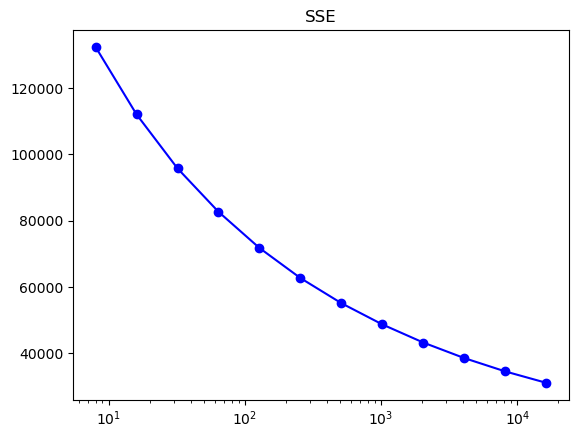

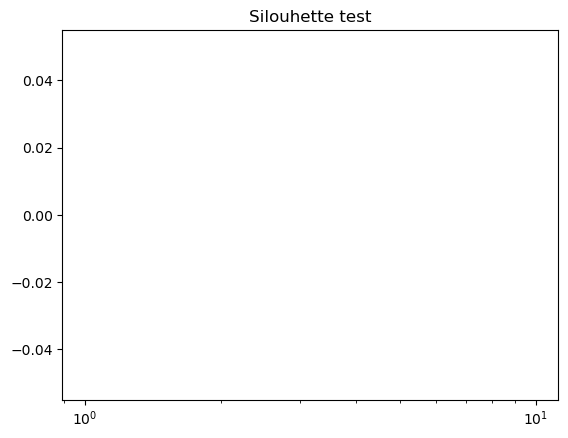

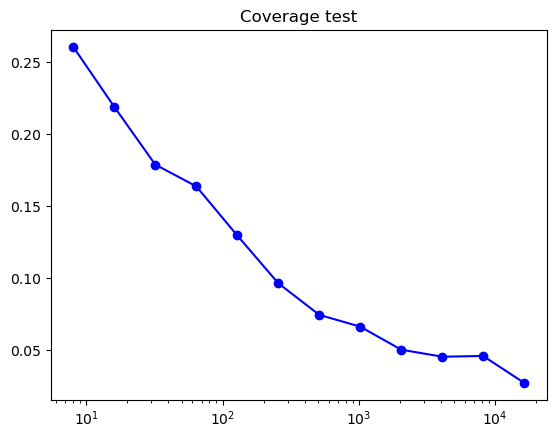

In [57]:
plt.plot(n_clusters[:len(inertias)],inertias,color='b',marker='o')
plt.xscale('log')
plt.title('SSE')
plt.show()

plt.plot(n_clusters[:len(silouhettes)],silouhettes,color='b',marker='o')
plt.xscale('log')
plt.title('Silouhette test')
plt.show()

plt.plot(n_clusters[:len(coverages)],coverages,color='b',marker='o')
plt.xscale('log')
plt.title('Coverage test')
plt.show()

# ax.plot([],[],color='orange',label='Silhouette')
# ax2.plot(n_clusters,silouhettes,color='orange')
# ax.legend(loc='upper right')
# ax.set_xticks(n_clusters)

# ax.set_xlabel(r'Number of clusters')
# ax.set_ylabel(r'SSE $\sum_i \min_{\mu_j \in C} |x_i- \mu_j|^2$')
# # ax.set_xlabel(r'SSE $\sum_i \min_{\mu_j \in C}(\abs{x_i- \mu_j})^2$')

# ax2.set_ylabel('Silhouette score')
# ax.set_xscale('log')

# plt.show()

# t-SNE

In [145]:
kmeans = KMeans(
    n_clusters = 2,
    init = 'k-means++',
    max_iter = 1000,
    verbose = 0,
)
kmeans.fit(latent_train[:1000000])

centers = kmeans.cluster_centers_

tsne = TSNE(
    n_components = 2,
    verbose = 1,
)

N = 20000
idx_latent = torch.randperm(latent_valid.shape[0])[:N]
latent_select = latent_valid[idx_latent]
process_select = process_valid[idx_latent]
idx_centers = kmeans.predict(latent_select)

tsne_input = np.concatenate(
    (
        latent_select,
        centers,
    )
)
tsne_output = tsne.fit_transform(tsne_input)

latent_tsne = tsne_output[:N]
centers_tsne = tsne_output[N:]



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20002 samples in 0.001s...
[t-SNE] Computed neighbors for 20002 samples in 0.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20002
[t-SNE] Computed conditional probabilities for sample 2000 / 20002
[t-SNE] Computed conditional probabilities for sample 3000 / 20002
[t-SNE] Computed conditional probabilities for sample 4000 / 20002
[t-SNE] Computed conditional probabilities for sample 5000 / 20002
[t-SNE] Computed conditional probabilities for sample 6000 / 20002
[t-SNE] Computed conditional probabilities for sample 7000 / 20002
[t-SNE] Computed conditional probabilities for sample 8000 / 20002
[t-SNE] Computed conditional probabilities for sample 9000 / 20002
[t-SNE] Computed conditional probabilities for sample 10000 / 20002
[t-SNE] Computed conditional probabilities for sample 11000 / 20002
[t-SNE] Computed conditional probabilities for sample 12000 / 20002
[t-SNE] Computed conditional probabilities for sam

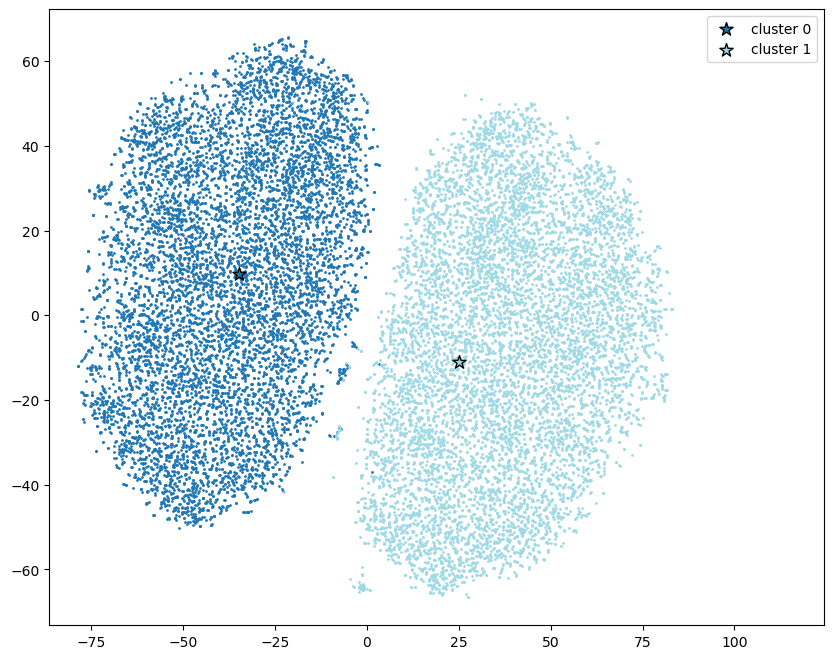

In [146]:
fig = plt.figure(figsize=(10,8))
colors = plt.cm.tab20(np.linspace(0, 1, len(centers)))
for idx in range(len(centers)):
    mask = idx_centers == idx
    plt.scatter(
        latent_tsne[mask,0],
        latent_tsne[mask,1],
        s = 1,
        color = colors[idx],
    )
    plt.scatter(
        centers_tsne[idx,0],
        centers_tsne[idx,1],
        s = 100,
        marker = '*',
        color = colors[idx],
        edgecolor = 'k',
        label = f'cluster {idx}'
    )
plt.xlim(latent_tsne[:,0].min()*1.1,latent_tsne[:,0].max()*1.5)
plt.legend(loc='upper right')
plt.show()

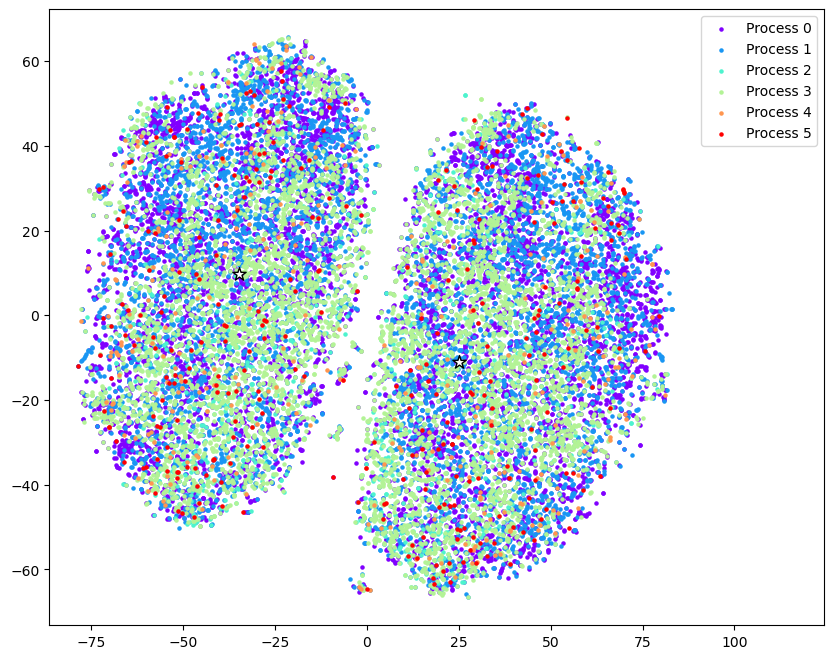

In [147]:
fig = plt.figure(figsize=(10,8))
processes = torch.unique(process_select).sort()[0]
colors = plt.cm.rainbow(np.linspace(0, 1, len(processes)))
for i,process in enumerate(processes):
    mask = process_select == process
    plt.scatter(
        latent_tsne[mask,0],
        latent_tsne[mask,1],
        s = 5,
        color = colors[i],
        label = f'Process {process}'
    )
for idx in range(len(centers)):
    plt.scatter(
        centers_tsne[idx,0],
        centers_tsne[idx,1],
        s = 100,
        marker = '*',
        edgecolor = 'k',
        color = 'white',
    )
plt.xlim(latent_tsne[:,0].min()*1.1,latent_tsne[:,0].max()*1.5)
plt.legend(loc='upper right')
plt.show()

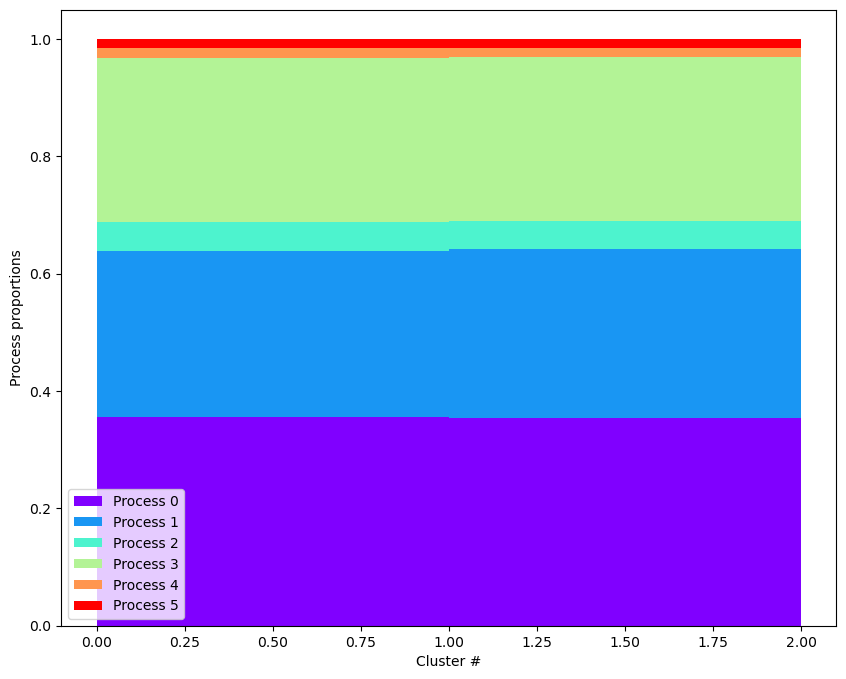

In [148]:
fig = plt.figure(figsize=(10,8))
processes = torch.unique(process_select).sort()[0]
cluster_content = [[] for _ in range(len(processes))]
colors = plt.cm.rainbow(np.linspace(0, 1, len(processes)))

for idx in range(len(centers)):
    for i,process in enumerate(processes):
        mask = np.logical_and(
            idx_centers == idx,
            process_select == process,
        )
        cluster_content[i].append(mask.sum().item())
cluster_content = np.array(cluster_content)
cluster_content = cluster_content / cluster_content.sum(axis=0)

bottom = np.zeros(len(centers))
for i,process in enumerate(processes):
    plt.bar(
        x = torch.arange(len(centers))+0.5,
        width = 1.0,
        height = cluster_content[i],
        color = colors[i],
        bottom = bottom,
        label = f'Process {i}',
    )
    bottom += cluster_content[i]
plt.legend()
plt.xlabel('Cluster #')
plt.ylabel('Process proportions')
plt.show()

# Study distributions 

In [149]:
from memflow.dataset.preprocessing import PreprocessingPipeline
preprocessing = PreprocessingPipeline.load('/nfs/scratch/fynu/fbury/MEMFlow_data/transfer_flow_v5/hh_reco/preprocessing/')
print (preprocessing)


Preprocessing steps
Step applied to ['electrons', 'muons']
	pt  : <class 'memflow.dataset.preprocessing.lowercutshift'>
  - electrons : ['pt']
  - muons     : ['pt']
Step applied to ['jets']
	pt  : <class 'memflow.dataset.preprocessing.lowercutshift'>
  - jets : ['pt']
Step applied to ['met', 'jets', 'electrons', 'muons']
	mass  : <class 'memflow.dataset.preprocessing.logmodulus'>
	pt    : <class 'memflow.dataset.preprocessing.logmodulus'>
  - met       : ['pt']
  - jets      : ['pt', 'mass']
  - electrons : ['pt', 'mass']
  - muons     : ['pt', 'mass']
Step applied to ['met', 'jets', 'electrons', 'muons']
	charge  : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	eta     : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	mass    : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	pdgId   : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	phi     : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	pt      : <class 'memflow.dataset.preprocessing.SklearnScal

In [150]:
number_particles_per_type = [2,2,1,4]
features = [['pt','eta','phi','mass','btag','pdgId','charge'] for _ in range(len(number_particles_per_type))]
selection = ['muons','electrons','met','jets']
x_raw = list(torch.split(x_valid,number_particles_per_type,dim=1))
if not mask_valid.dtype == torch.bool:
    mask_valid = mask_valid > 0
mask_raw = torch.split(mask_valid,number_particles_per_type,dim=1)
for i in range(len(x_raw)):
    x_raw[i],features[i] = preprocessing.inverse(
        x = x_raw[i],
        mask = mask_raw[i],
        name = selection[i],
        fields = features[i],
    )
print (x_raw)
print (features)

[tensor([[[ 9.1064e+01, -5.5408e-01, -9.8059e-01,  ...,  0.0000e+00,
           1.3000e+01, -1.0000e+00],
         [ 3.4288e+01,  6.8079e-01, -2.0024e+00,  ...,  0.0000e+00,
          -1.3000e+01,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 7.7182e+01, -6.8069e-02, -3.0093e+00,  ...,  0.0000e+00,
          -1.3000e+01,  1.0000e+00]],

        [[ 3.9854e+01, -7.9712e-01,  2.2192e+00,  ...,  0.0000e+00,
           1.3000e+01, -1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.6509e+01,  1.7610e+00,  9.0747e-01,  ...,  0.0000e+00,
          -1.3000e+01,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+

In [151]:
def plot_cluster(cluster):
    idx_cluster = kmeans.predict(latent_valid)
    mask_cluster = idx_cluster == cluster

    for i in range(len(x_raw)):
        for j in range(x_raw[i].shape[1]):
            n = len(features[i])
            fig,axs = plt.subplots(ncols=n,figsize=(n*5,4))
            fig.suptitle(f'Cluster {cluster} : {selection[i]} #{j} [{mask_raw[i][:,j].sum():d} particles]')
            for k in range(n):
                x_feat = x_raw[i][:,j,k][mask_raw[i][:,j]>0]
                bins = np.linspace(x_feat.min(),x_feat.max(),51)
    
                mask_sel = np.logical_and(
                    mask_cluster,
                    mask_raw[i][:,j]>0,
                )
                x_sel = x_raw[i][:,j,k][mask_sel]
                axs[k].hist(x_feat,bins=bins,histtype='step',color='b',density=False)
                axs[k].hist(x_sel,bins=bins,histtype='step',color='orange',density=False)
                axs[k].set_xlabel(features[i][k])
                axs[k].set_yscale('log')
    plt.show()

/nfs/scratch/fynu/fbury/ipykernel_2769666/3073906784.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/IndexingUtils.h:27.)
  x_sel = x_raw[i][:,j,k][mask_sel]


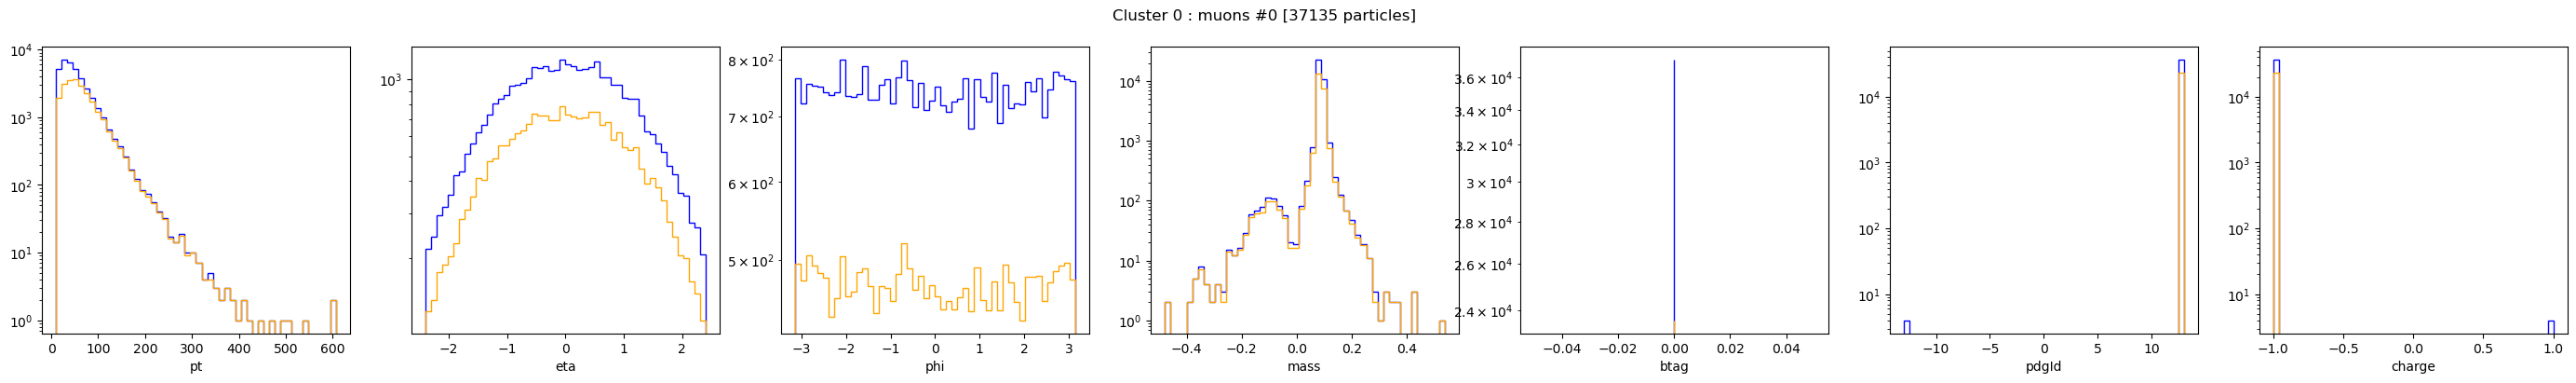

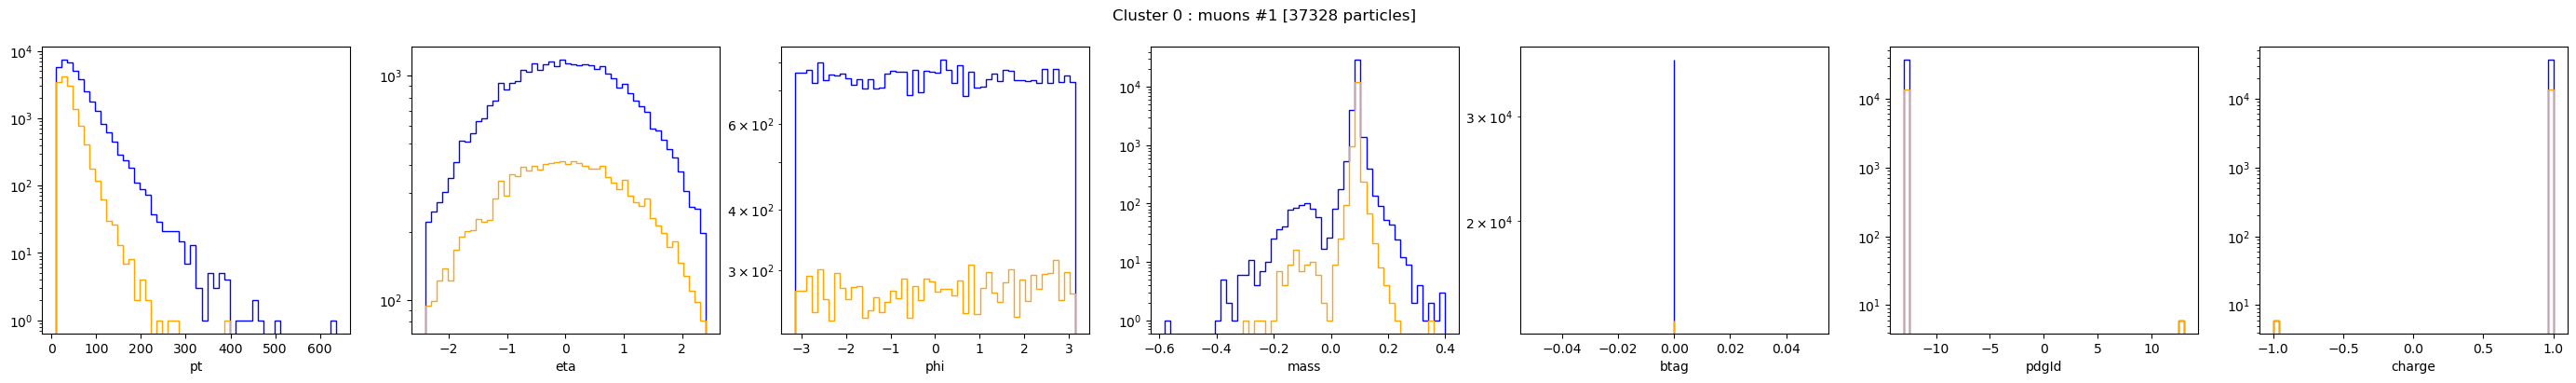

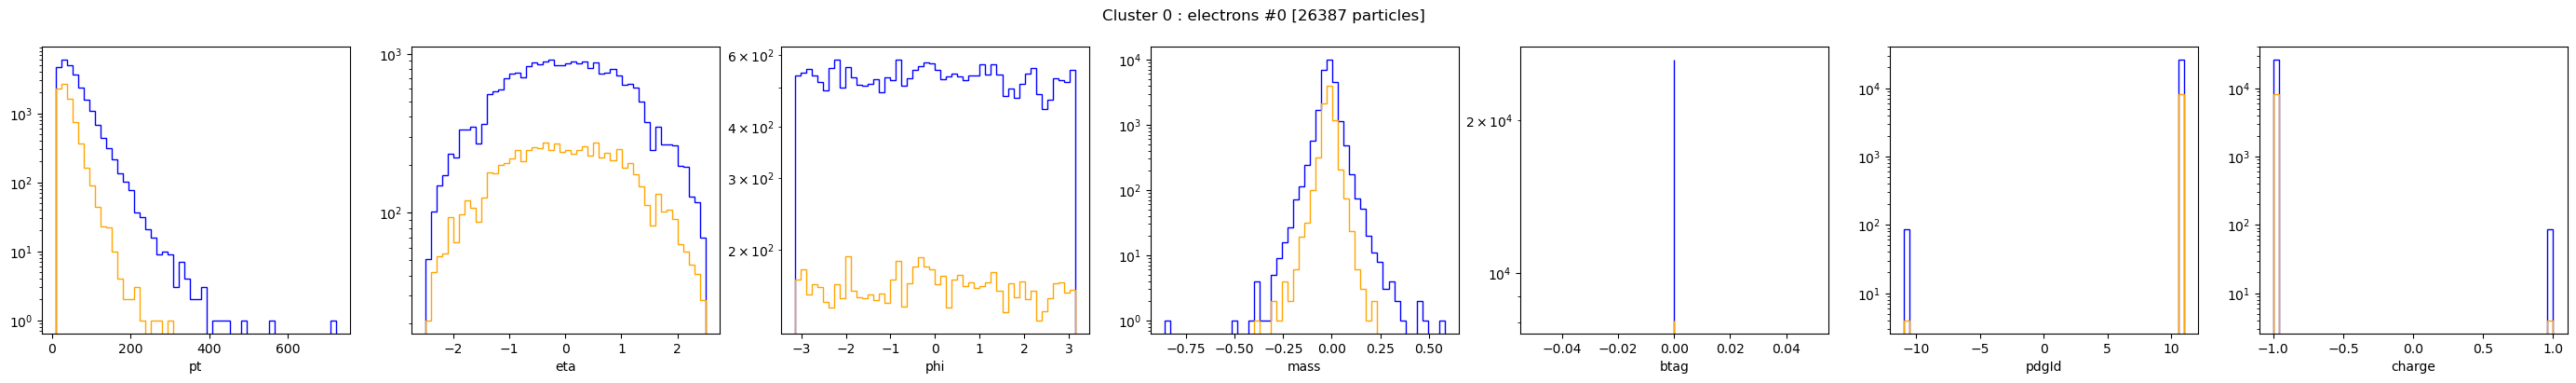

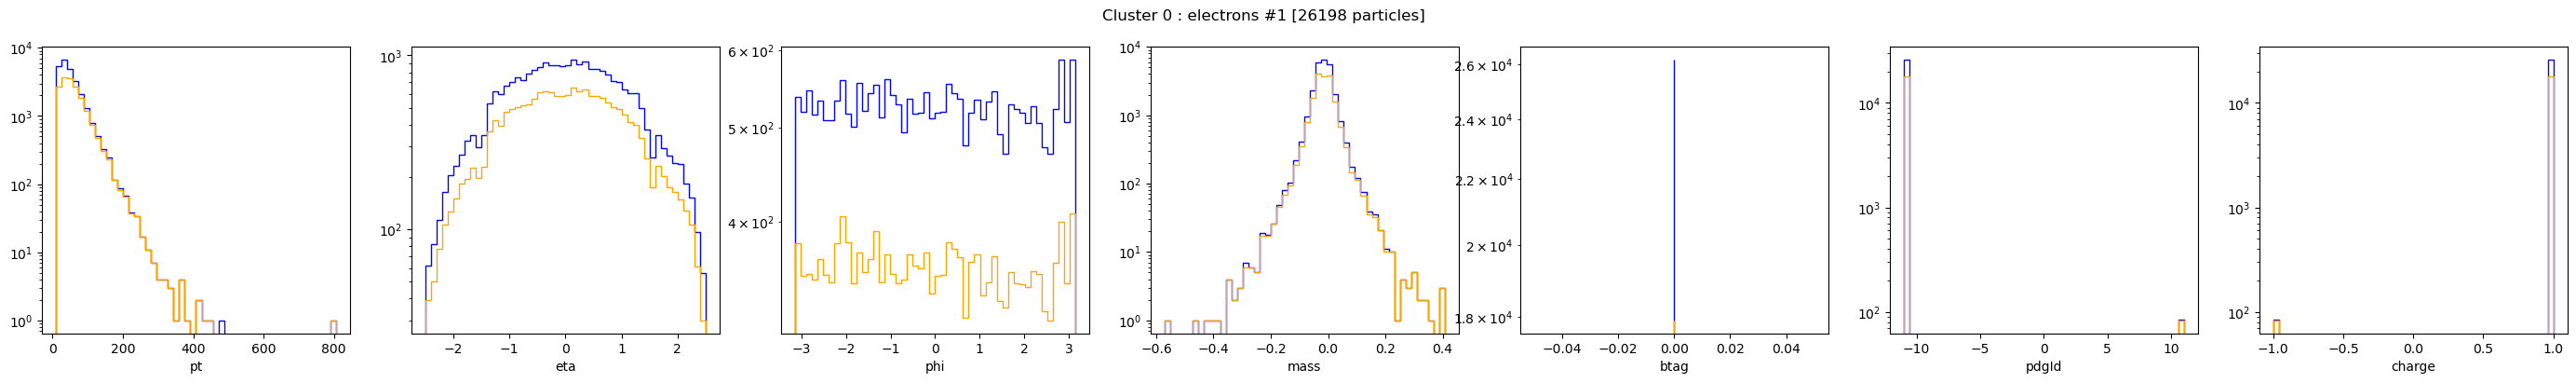

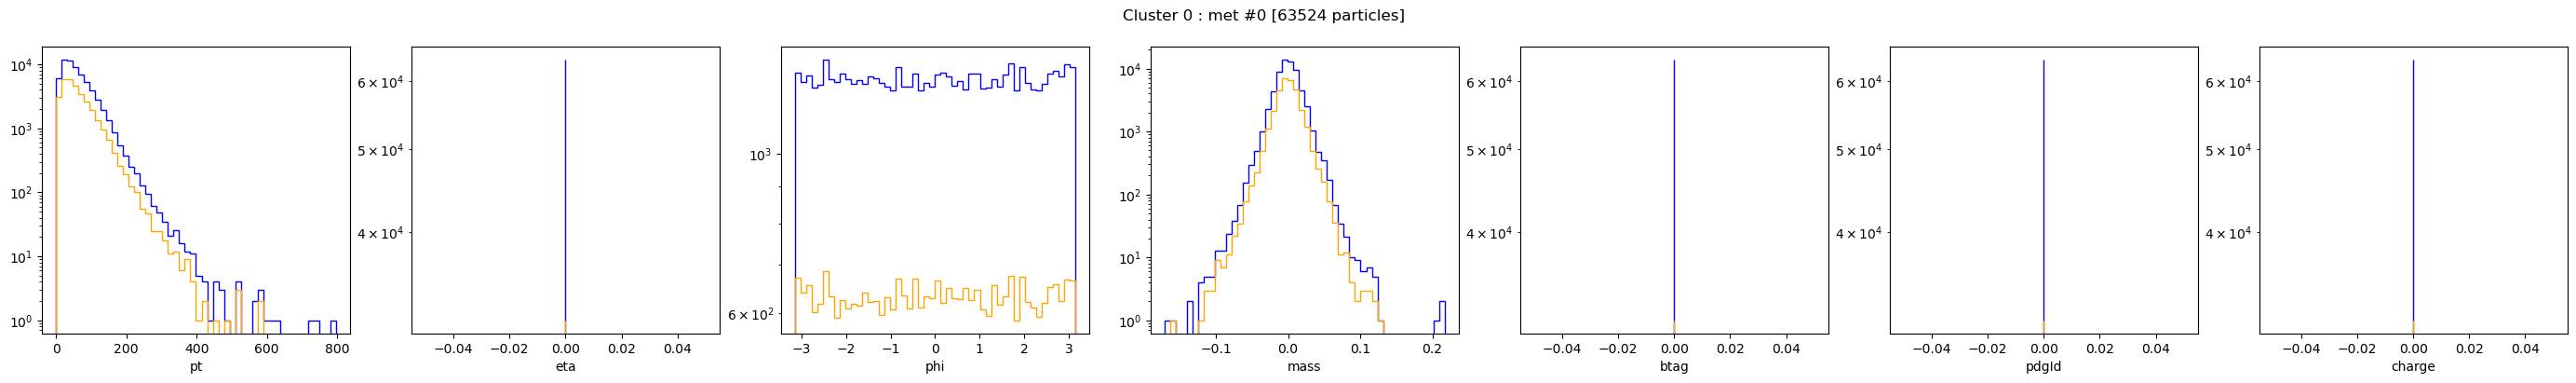

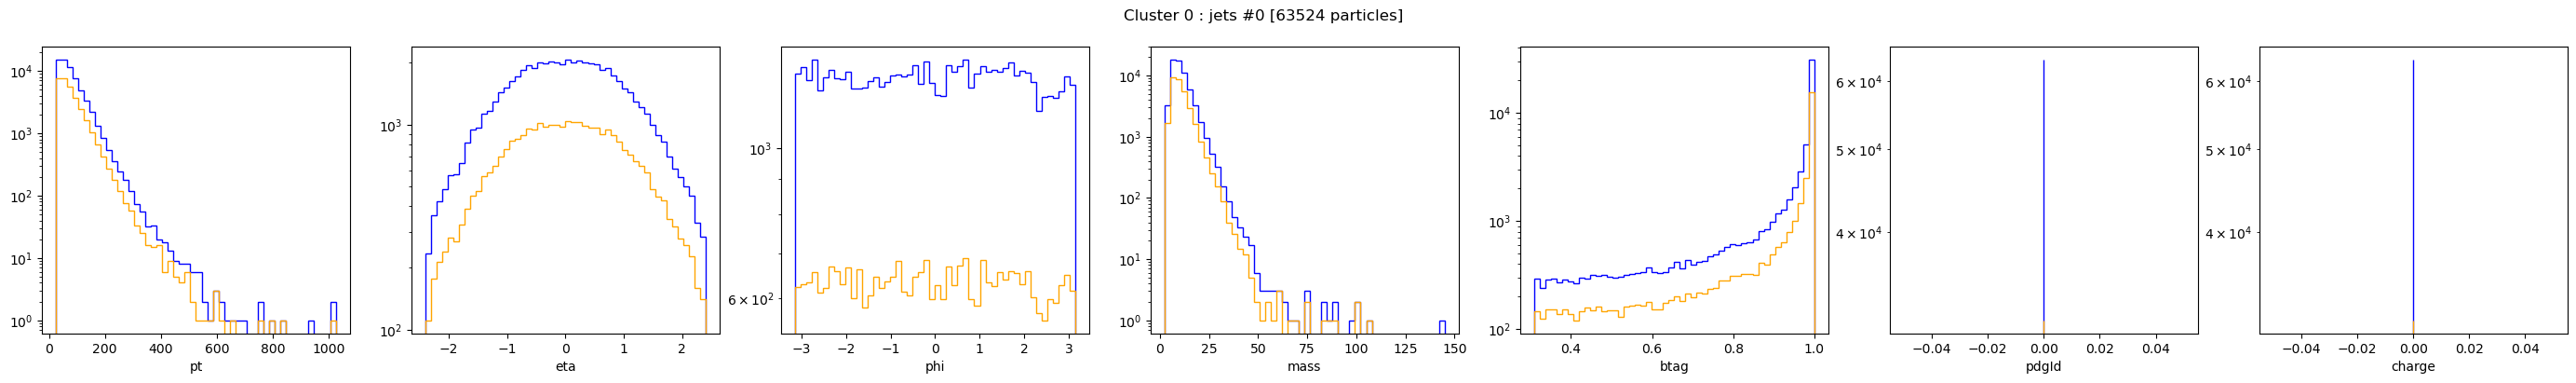

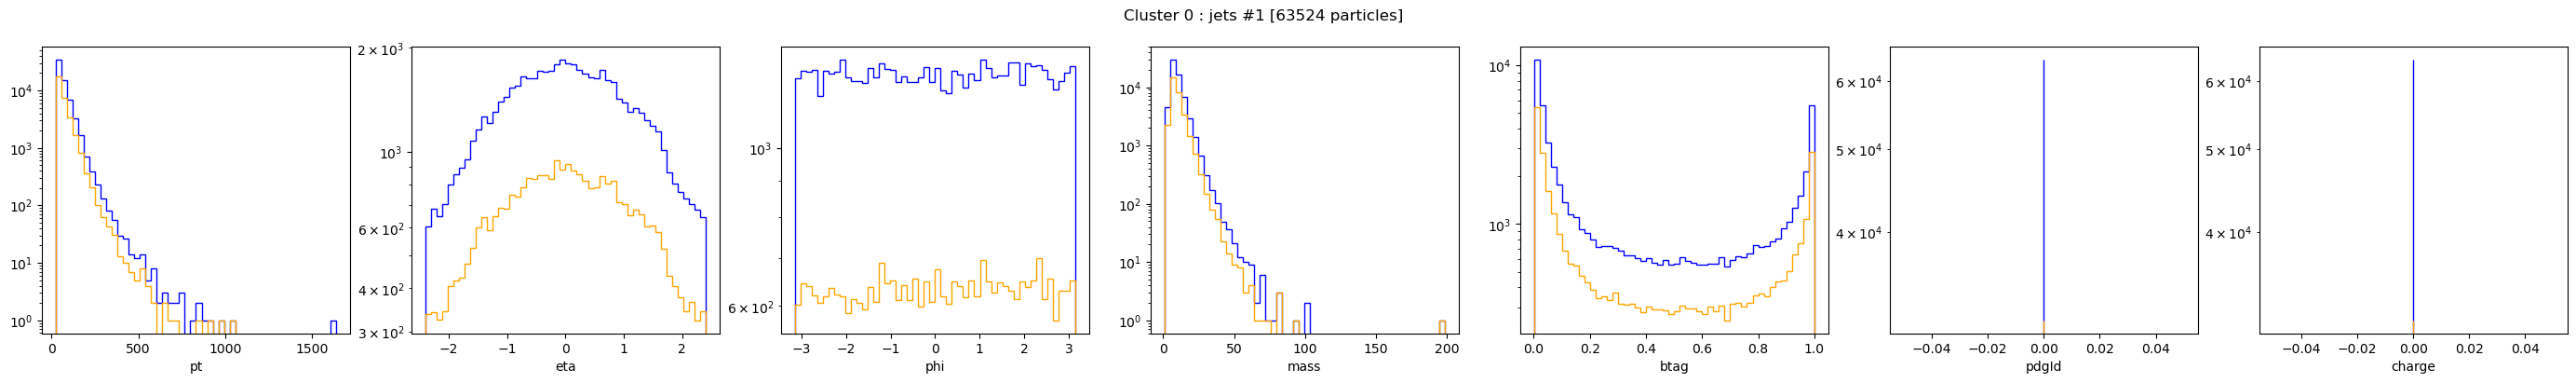

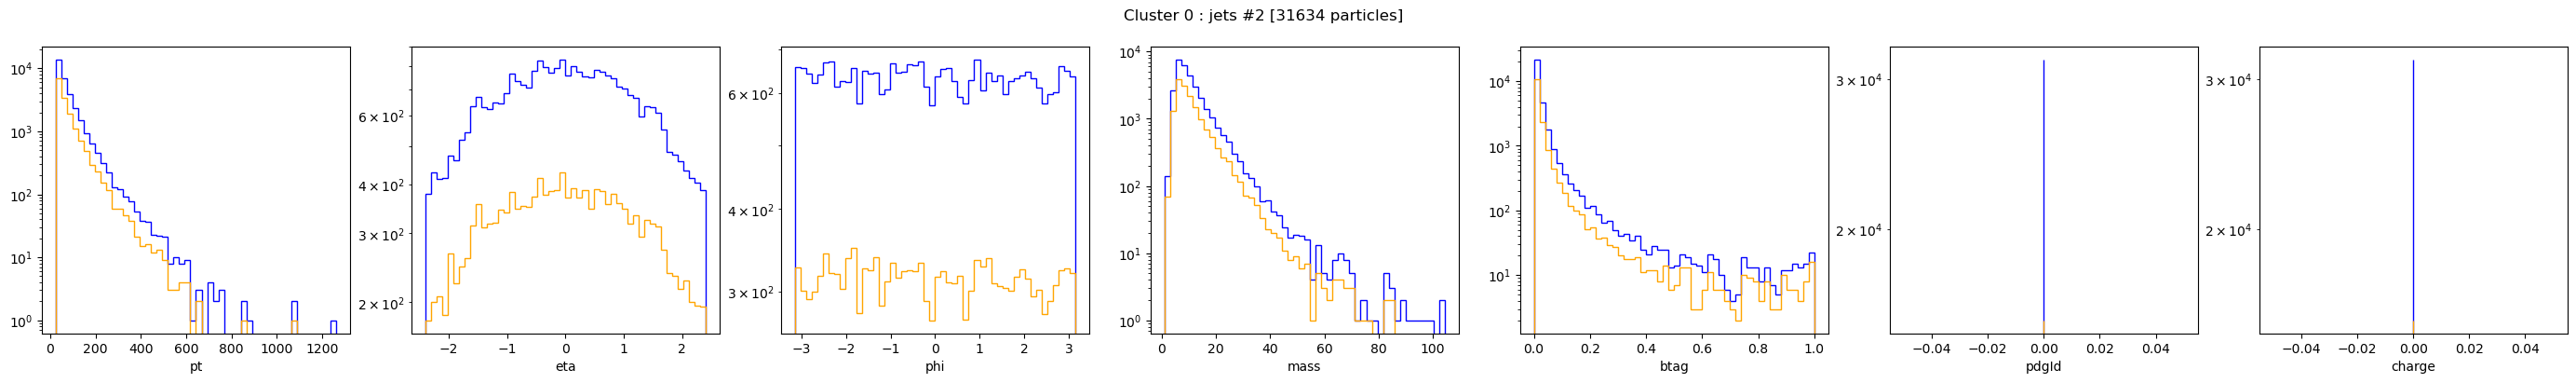

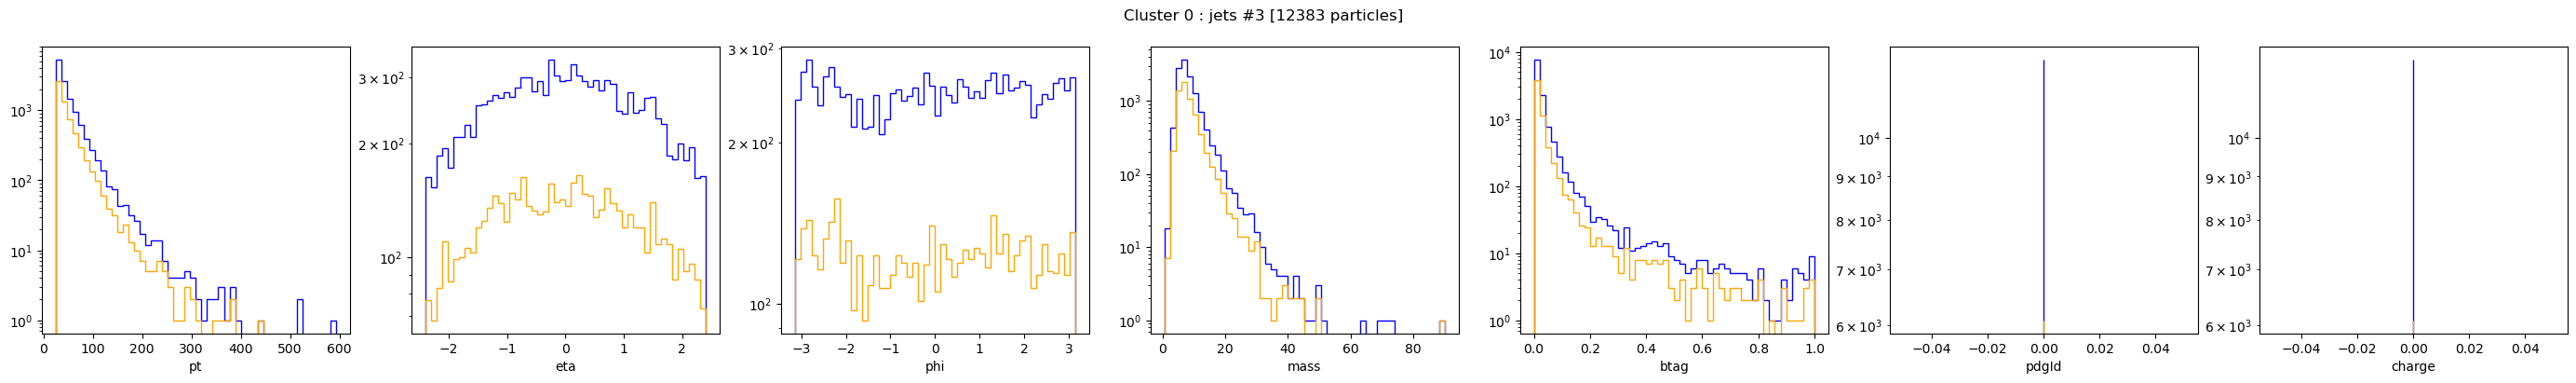

In [152]:
plot_cluster(0)

/nfs/scratch/fynu/fbury/ipykernel_2769666/3073906784.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/IndexingUtils.h:27.)
  x_sel = x_raw[i][:,j,k][mask_sel]


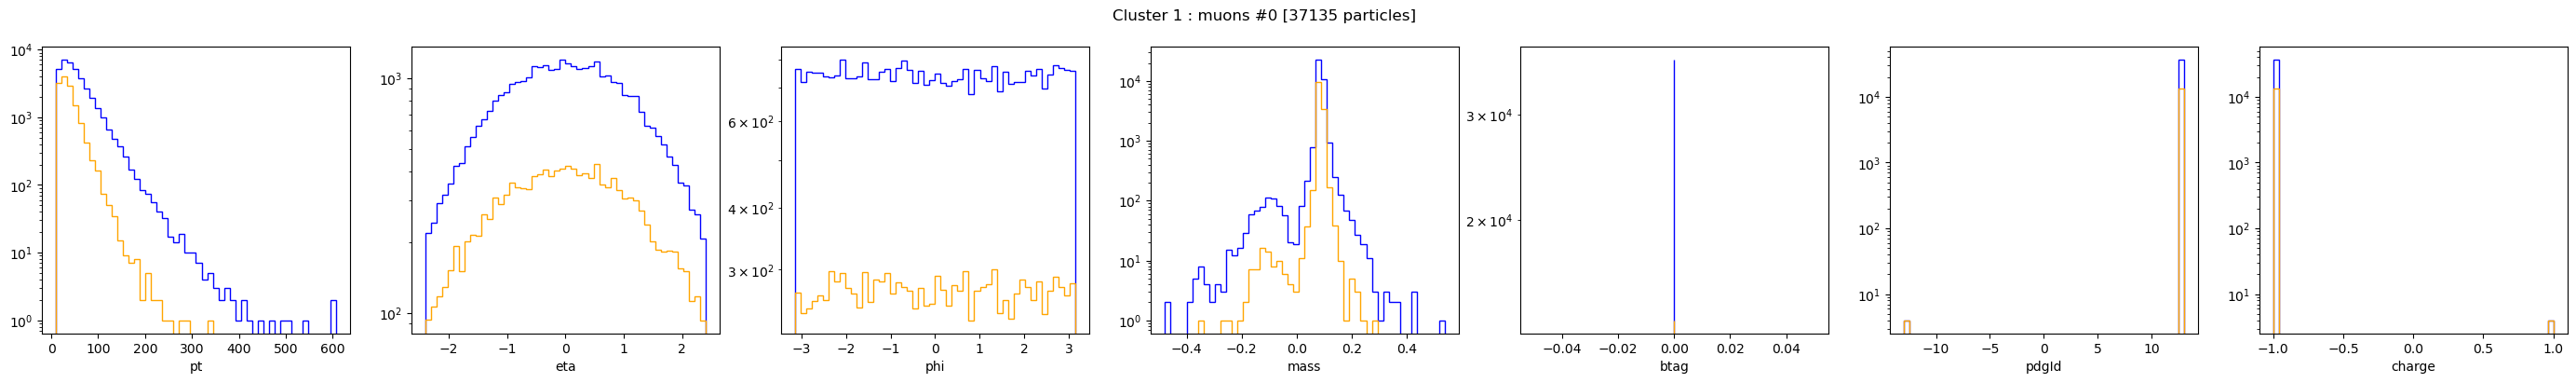

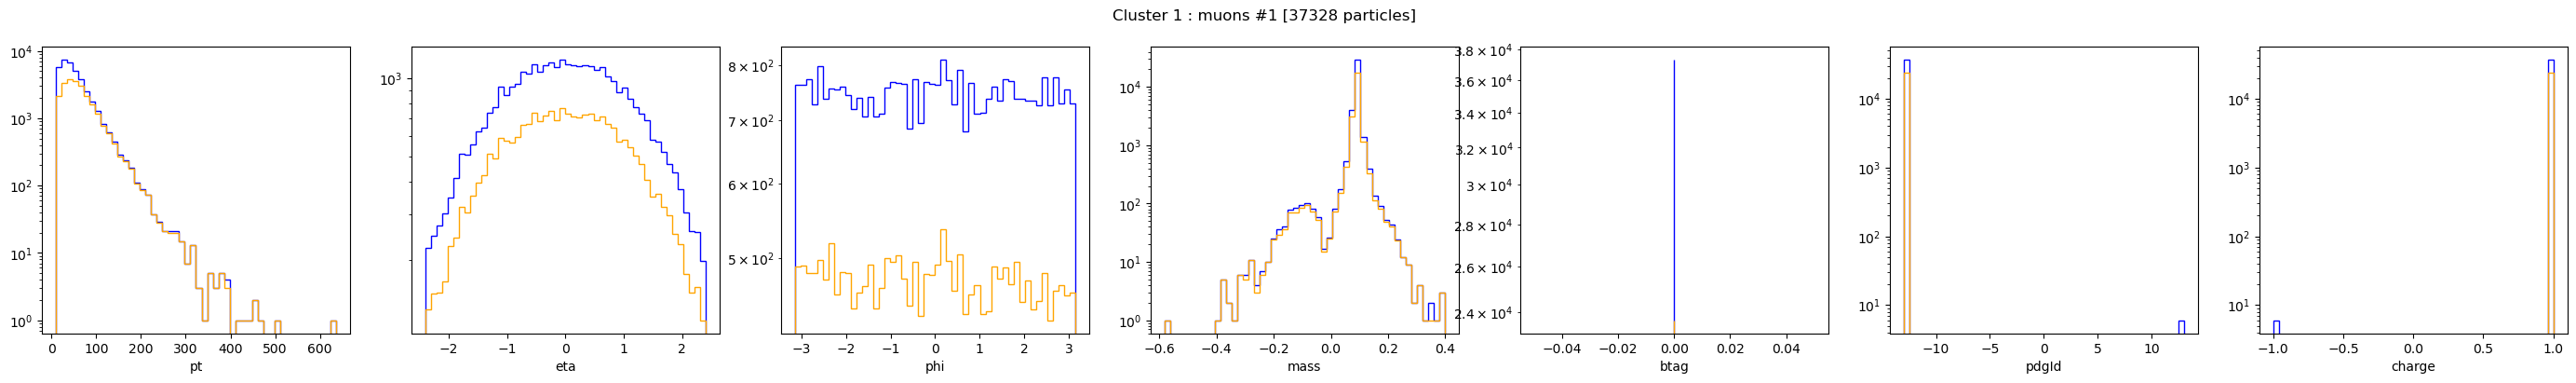

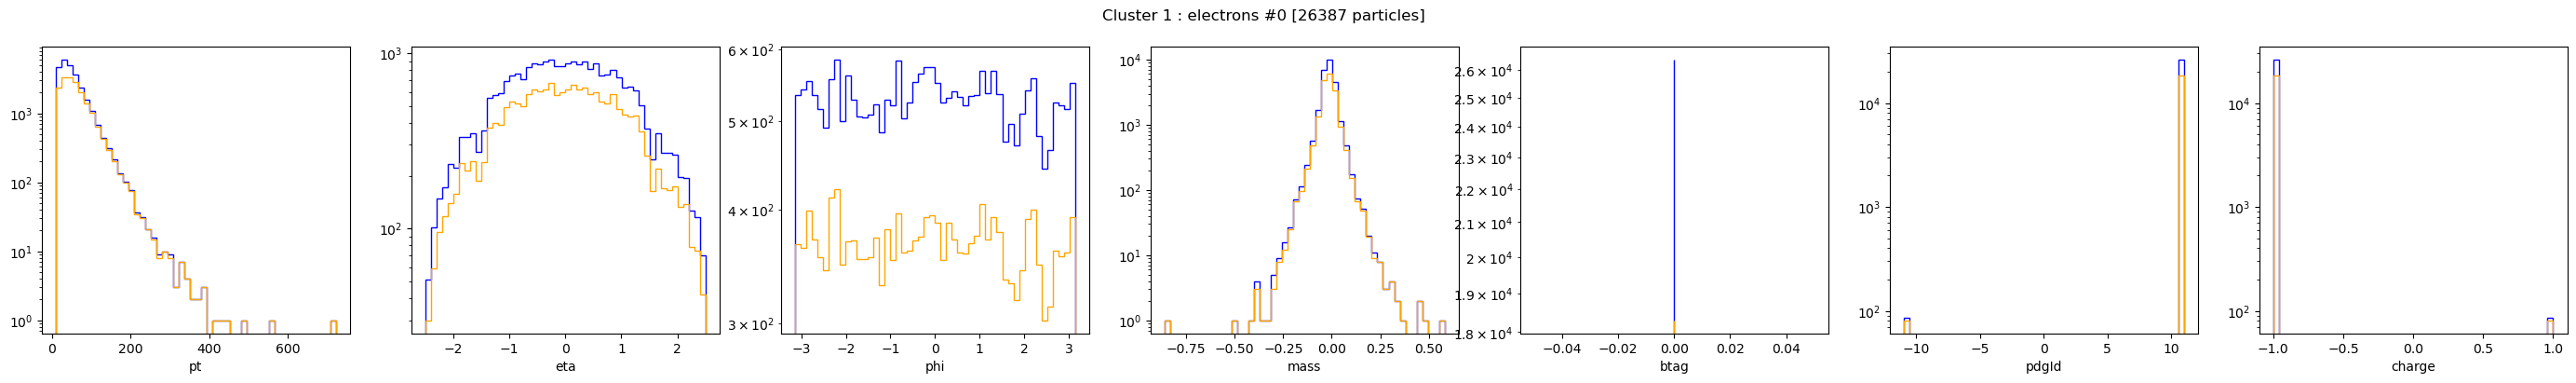

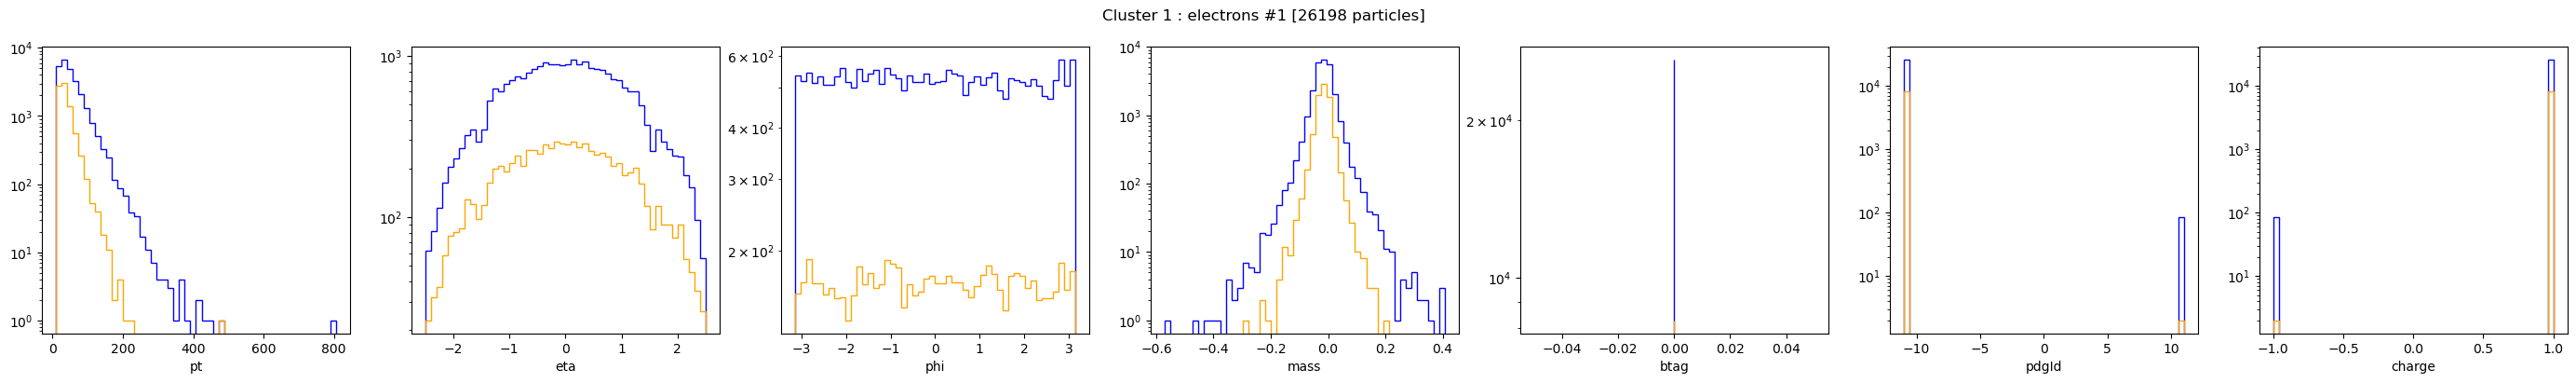

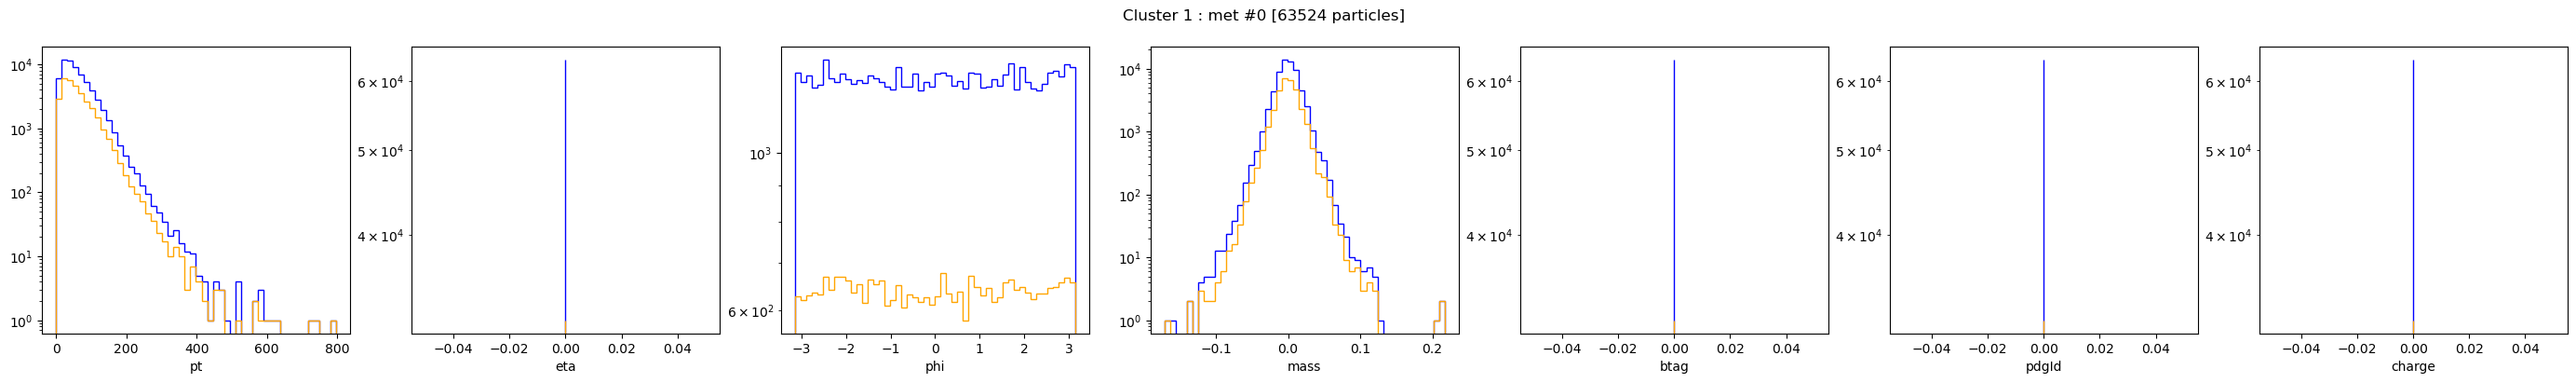

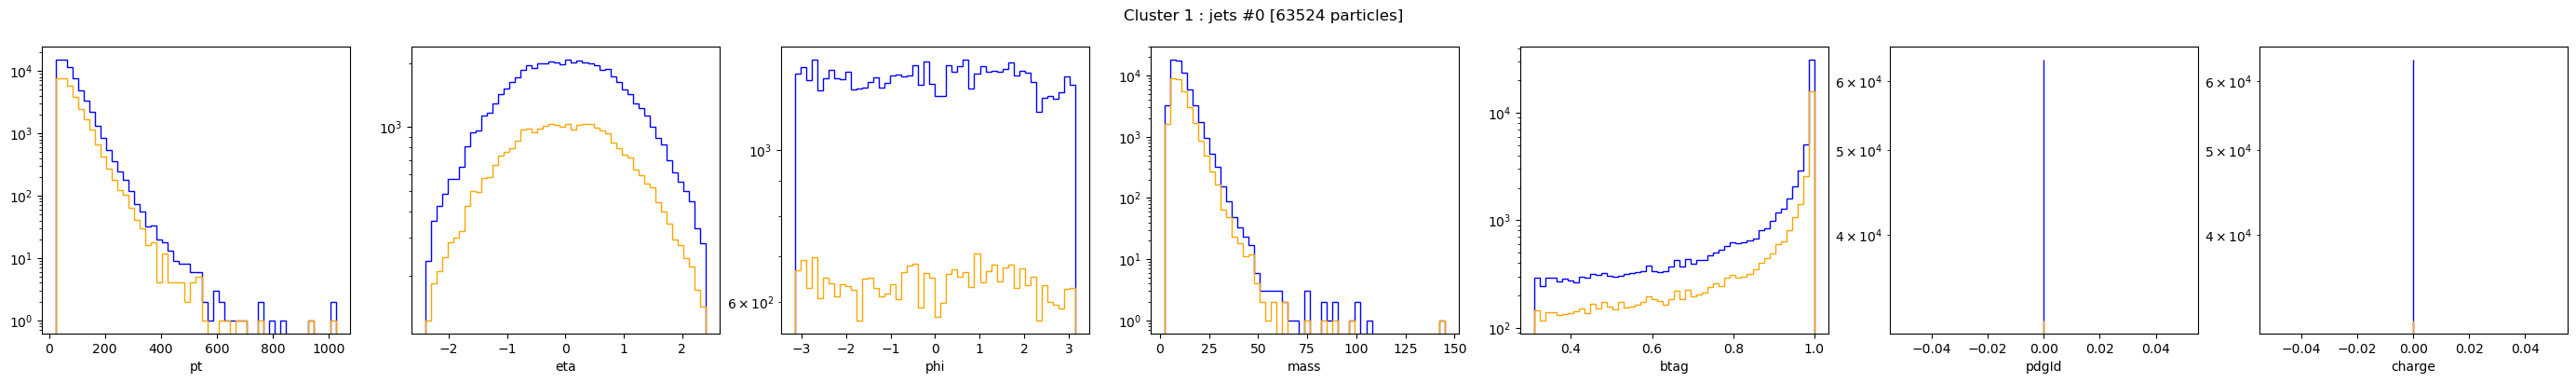

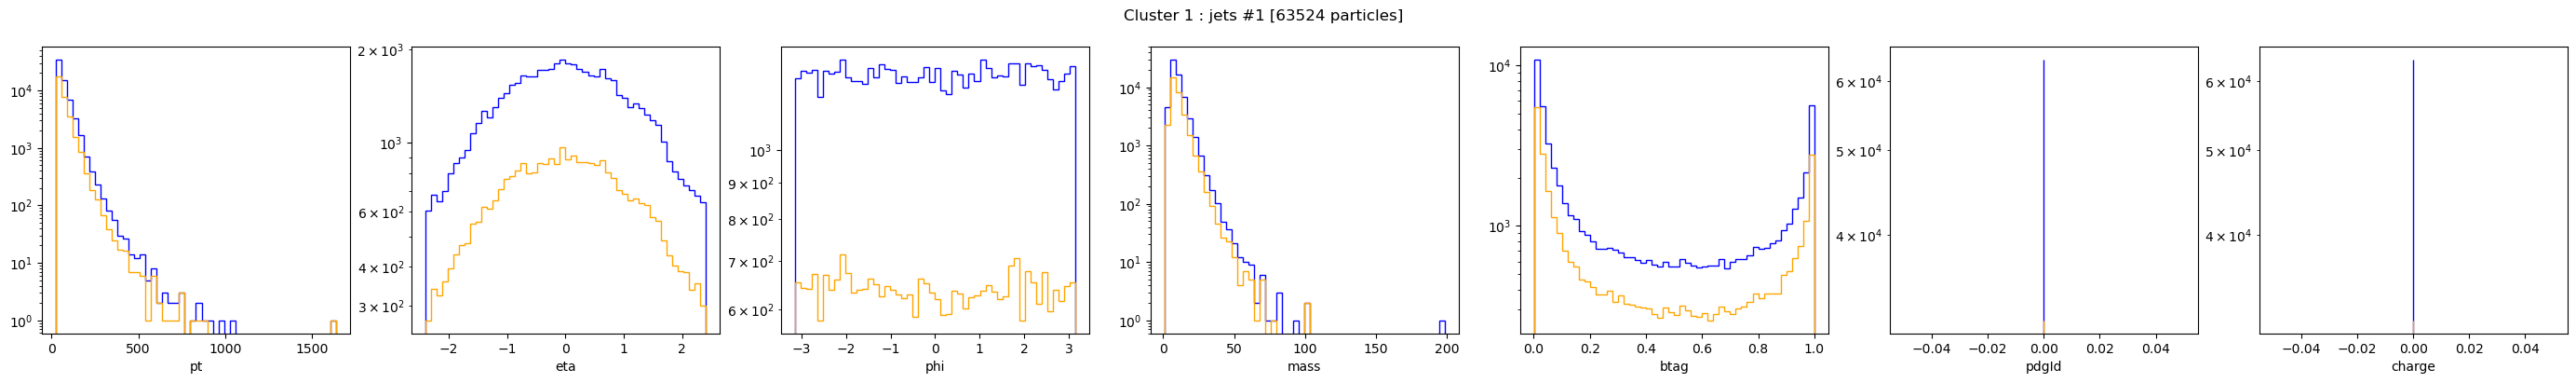

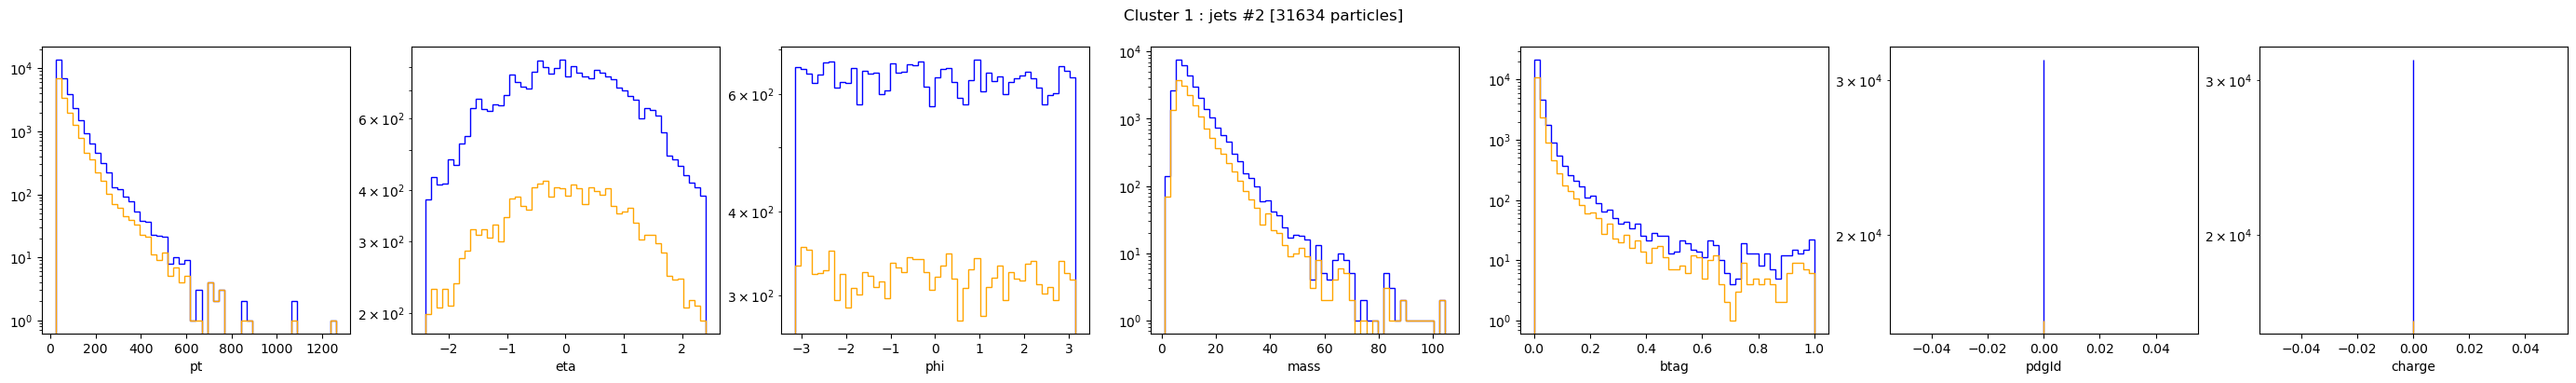

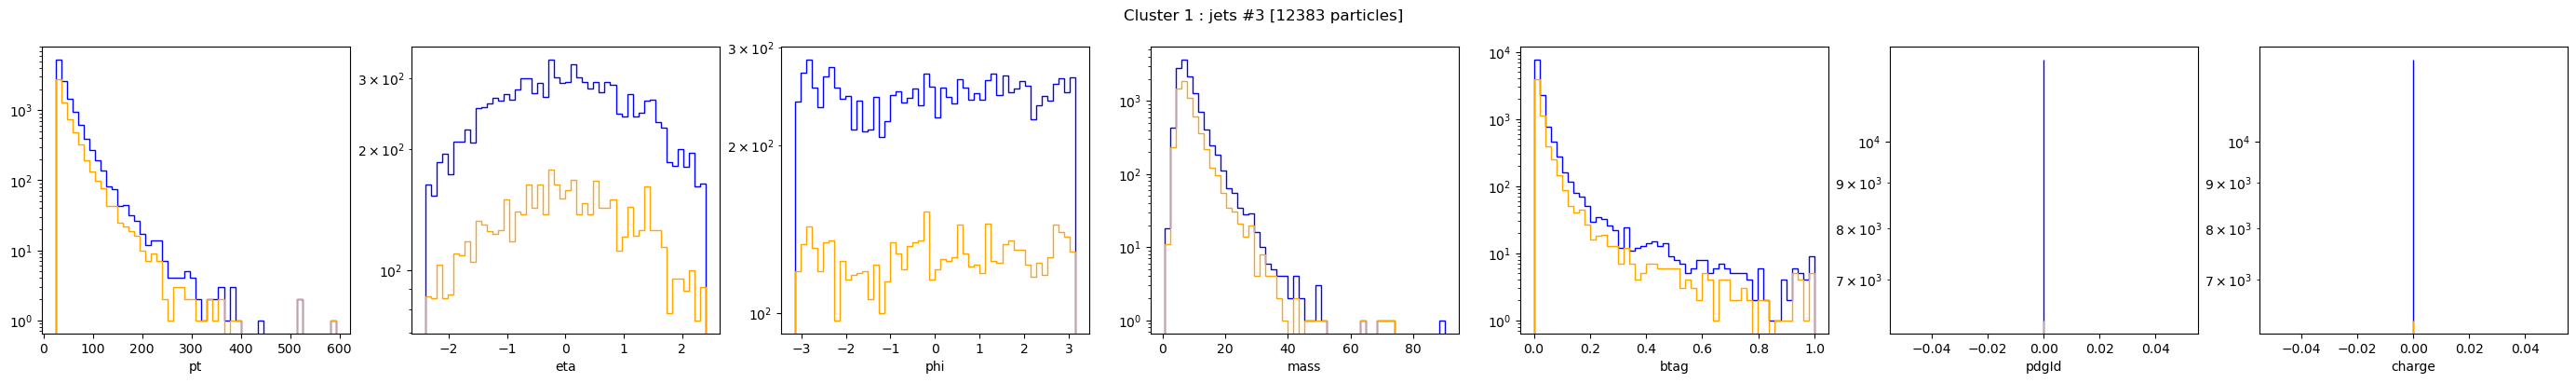

In [153]:
plot_cluster(1)

In [90]:
centers = kmeans.cluster_centers_
dist = cdist(centers,centers)
idx = dist.argmax()
print ()
i_0 = idx%len(centers)
i_1 = idx//len(centers)
print (dist.max(),dist[i_0,i_1])
print (i_0,i_1)


3.5635793325246747 3.5635793325246747
13 6
